# Poisson's Equation

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import imageio

# Visualization

The function `poisson_square` implements the finite difference method using `scipy.sparse.linalg.spsolve` to solve a linear system. We use this function to solve the boundary value problem:

\begin{align}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1])
\end{align}

With $n=100$ subintervals for both $x$ and $y$. We plot the solution as a 3D surface.

In [10]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # initialize x and y grid
    x, h = np.linspace(a, b, n+1, retstep=True)
    y = np.linspace(c, d, n+1)

    # create p
    p = np.array([np.concatenate(([g(x[0], y[j]) / h**2], [0] * (n-3), [g(x[n], y[j]) / h**2])) for j in range(1, n)])

    # create q
    q1 = np.array([g(x[i],y[0])/h**2 for i in range(1, n)])
    qf = np.array([g(x[i],y[n])/h**2 for i in range(1, n)])
    mid = np.zeros(n-1)
    q = np.concatenate(([q1], [mid]*(n-3), [qf]))

    # create f
    func = np.array([[f(x[i], y[j]) for i in range(1, n)] for j in range(1, n)])

    # create A
    T = sp.diags([1,-4,1],[-1,0,1],shape=(n-1,n-1))
    middle = sp.block_diag([T] * (n - 1))
    lower = sp.diags([np.ones((n-1) * (n-2))], [-(n-1)])
    upper = sp.diags([np.ones((n-1) * (n-2))], [n-1])
    A = (middle + lower + upper) / h**2

    # solve for U and return
    return spla.spsolve(A, np.ravel(func - p - q)).reshape(n-1, n-1)

In [4]:
a, b, c, d = 0, 1, 0, 1
f = lambda x,y: 0
g = lambda x,y: x**3
n = 100
surface = poisson_square(a,b,c,d,f,g,n)

# plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.linspace(a, b, n-1), np.linspace(c, d, n-1)
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, surface, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Poisson Equation on a Square')
plt.show()

<IPython.core.display.Javascript object>

![name](poisson_square.png)

# Application: Charge Density

We solve 

\begin{align}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
\end{align}

for the electric potential $V.$ We use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. We have $n=100$ subintervals for $x$ and $y$ to plot the solution.

In [16]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n = 100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X, Y = np.meshgrid(X,Y)
f = lambda x,y: -1*source(x,y)
g = lambda x,y: 0

U = poisson_square(a1, b1, c1, d1, f, g, n)

plt.imshow(U, cmap=mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Relative Charge")
plt.title("Charge Density")
plt.show()

<IPython.core.display.Javascript object>

![name](charge_density1.png)

# Application: Cropping

Using the data file dr_jarvis.jpg as the source image $v$ and mount_rushmore.jpg as the destination image $u_0$, we put Dr. Jarvis' face on Mount Rushmore. We use the finite difference Laplacian operator to calculate $f$ from $v$ .

/home/dps2000/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


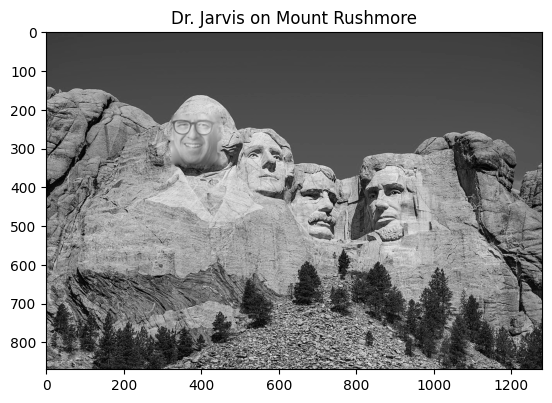

In [2]:
source = np.mean(imageio.v3.imread('./dr_jarvis.jpg'), axis=2).transpose() /255
dest = np.mean(imageio.v3.imread('./mount_rushmore.jpg'), axis=2).transpose() / 255

w = 130 # width and height to crop out.
x0s = 60 # position in source image
y0s = 84
x0 = 322 # position in destination image
y0 = 215
image = source[x0s-1:x0s+w+1,y0s-1:y0s+w+1]*0.58    # source image with a buffer of 1 pixel for the finite difference method.
                                                    # The buffer will need to be removed before inserting into the Mount
                                                    # Rushmore image. The '*0.58' will make it look better when displayed
        
# calculate f
Df_source = ((image[2:,:] - 2*image[1:-1, :] + image[:-2,:])[:,1:-1] +
             (image[:,2:] - 2*image[:,1:-1] + image[:,:-2])[1:-1,:])

# Create A
T = sp.diags([1,-4,1], [-1,0,1], shape=(w,w))
A = sp.block_diag([T]*(w))
A.setdiag(1, k=w)
A.setdiag(1, k=-w)
A.tocsr()

# Insert p and q into f
R = Df_source.copy()
R[0,:] -= dest[x0-1, y0:y0+w]
R[-1,:] -= dest[x0+w, y0:y0+w]
R[:,0] -= dest[x0:x0+w, y0-1]
R[:,-1] -= dest[x0:x0+w, y0+w]


# Get RHS
u = spla.spsolve(A, R.ravel())

# Insert u into the destination image
new_image = dest.copy()
new_image[x0:x0+w,y0:y0+w] = u.reshape(w,w)
plt.imshow(new_image.transpose(), cmap='gray')
plt.title("Dr. Jarvis on Mount Rushmore")
plt.savefig("/mnt/c/users/dalli/source/acme_senior/vl4labs/PoissonEquation/combined.png")
plt.show()

![name](combined.png)